In [1]:
from pipeline import (univariate_data_analysis, load_data, split_data, optimize_model, #compare_models,
split_univariate_sequence, objective, time_series_forecasting, prepare_data_for_optimization, create_optuna_model)
import pandas as pd

2025-04-03 22:15:42.128402: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743740142.160429  104617 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743740142.170099  104617 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 22:15:42.201032: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# First we load the data

In [2]:
df_filtered, df_info_filtered = load_data()

Info Filtered:
       M4id category  Frequency  Horizon      SP    StartingDate
99623   H38    Other         24       48  Hourly  01-07-15 12:00
99649   H64    Other         24       48  Hourly  01-07-15 12:00
99813  H228    Other         24       48  Hourly  15-05-10 12:00
99860  H275    Other         24       48  Hourly  02-01-10 12:00
99989  H404    Other         24       48  Hourly  06-01-17 12:00

Filtered Data (First Rows):
V1 Step  H404  H275     H64  H228     H38
0    V2  27.0  15.3  2777.0  12.4  3648.0
1    V3  22.0  15.0  2886.0  11.7  3658.0
2    V4  25.0  14.7  2811.0  11.1  3608.0
3    V5  25.0  14.4  2648.0  10.7  3493.0
4    V6  14.0  14.3  2618.0  10.3  3374.0


In [3]:
def index_date(ts):
    starting_date = df_info_filtered[df_info_filtered['M4id'] == ts]['StartingDate'].iloc[0]
    date_range = pd.date_range(start=starting_date, periods=len(df_filtered[ts]), freq='H')
    df_filtered[ts].index = date_range
    return df_filtered[ts].dropna()

ts = index_date('H404')

## Then we explore the series, with distribution, the ACF, PACF, moving avg, decomposition and descriptive statistics

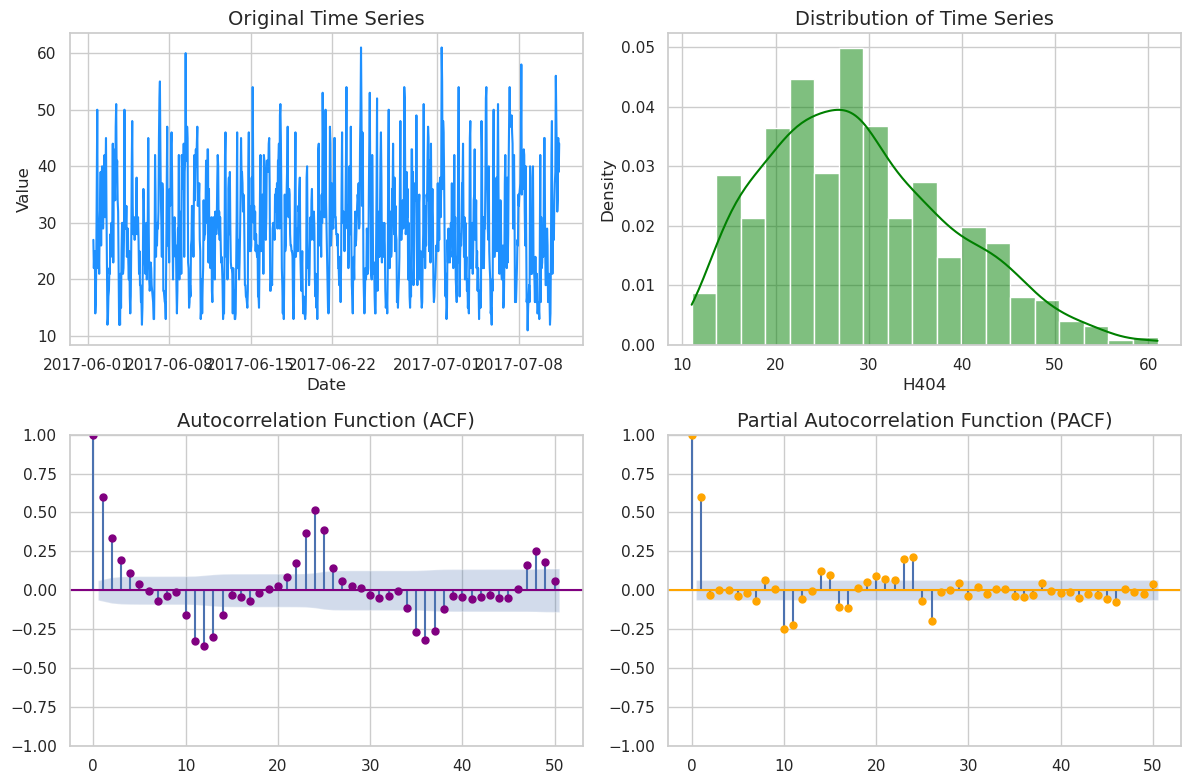

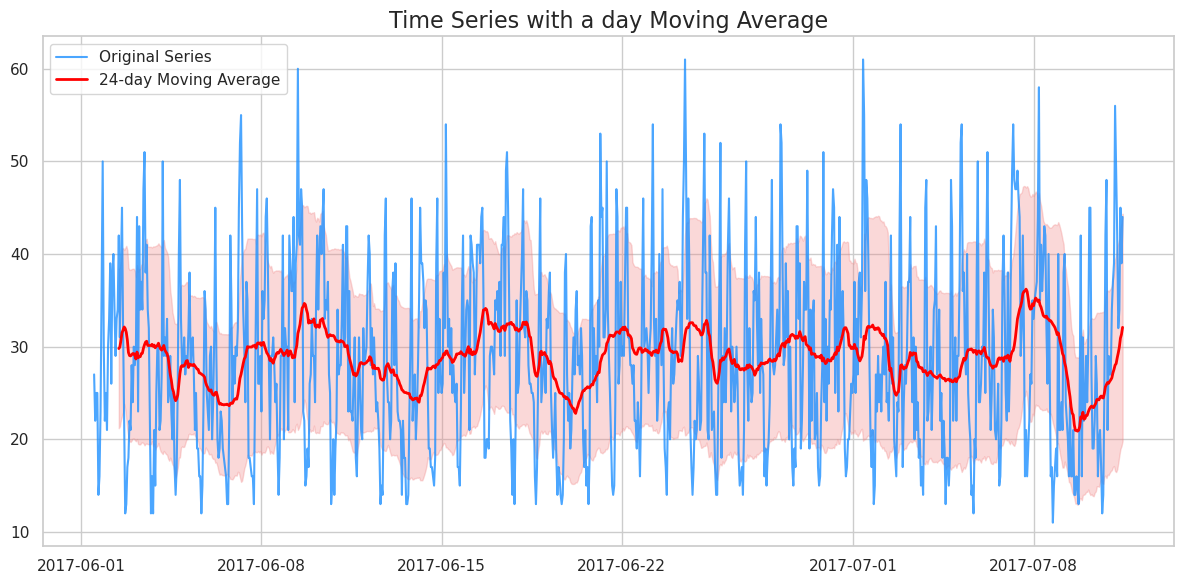

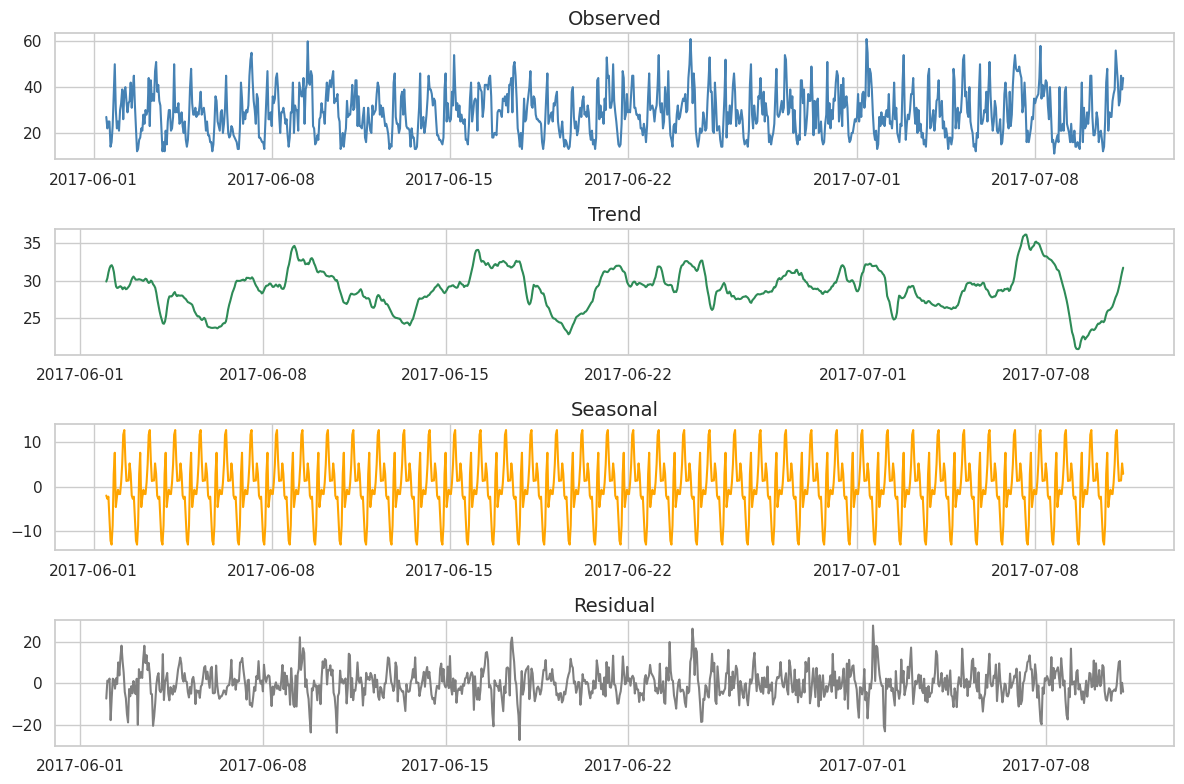

Descriptive Statistics:
count    960.000000
mean      28.957292
std        9.888284
min       11.000000
25%       21.750000
50%       28.000000
75%       35.000000
max       61.000000
Name: H404, dtype: float64

Shapiro-Wilk Test p-value: 8.486515526776039e-13
Interpretation: p < 0.05 suggests the data is not normally distributed

Augmented Dickey-Fuller Test for Stationarity:
ADF Statistic: -4.6334316179927475
p-value: 0.00011203167916002058
Interpretation:
p < 0.05: Reject null hypothesis (Series is stationary)
p >= 0.05: Fail to reject null hypothesis (Series might be non-stationary)


In [7]:
univariate_data_analysis(ts)

- **Distribution:**  
  The histogram appears to be a bit skewed and not normal with a mean around 28, suggesting as in the previous ts, multiple states, also the Shapiro-Wilk sugests no normaility, pretty much as the previous ts.
 
- **Autocorrelation:**  
  A pattern emerges **every 24 hours** as in other timeseries, but it is not as strong, but still exhibits **daily seasonality**, like in all other cases, maybe differentiating could help.  

- **Partial Autocorrelation:**  
  Significant spikes at the **first lag** indicate an **autoregressive component**. This means that **previous observations** have a **important impact** on the next ones.  

- **ADF Test:**  
  The test suggests that the series is **non-stationary**, aligning with the **seasonal patterns** previously observed and well defined also in the decomposition.  

- **Moving Average Analysis:**  
  The daily moving average captures the underlying trend while smoothing out the daily fluctuations, showing a fluctuating behavior. 

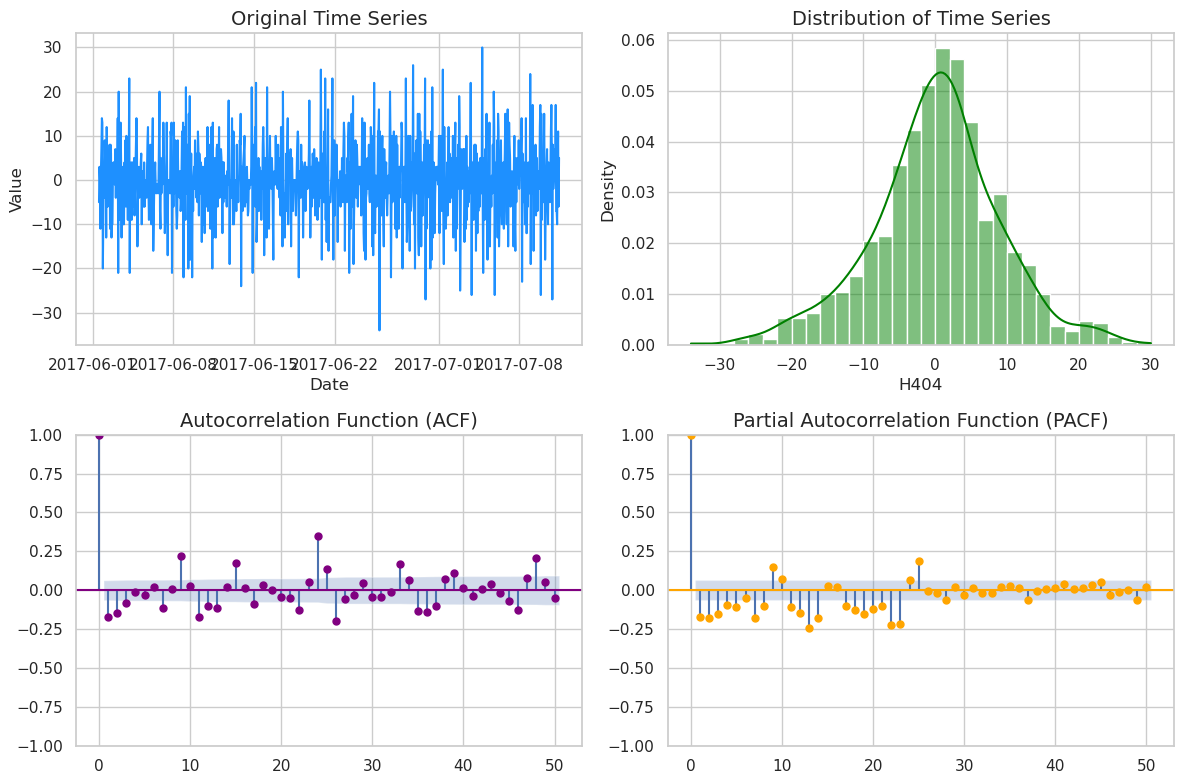

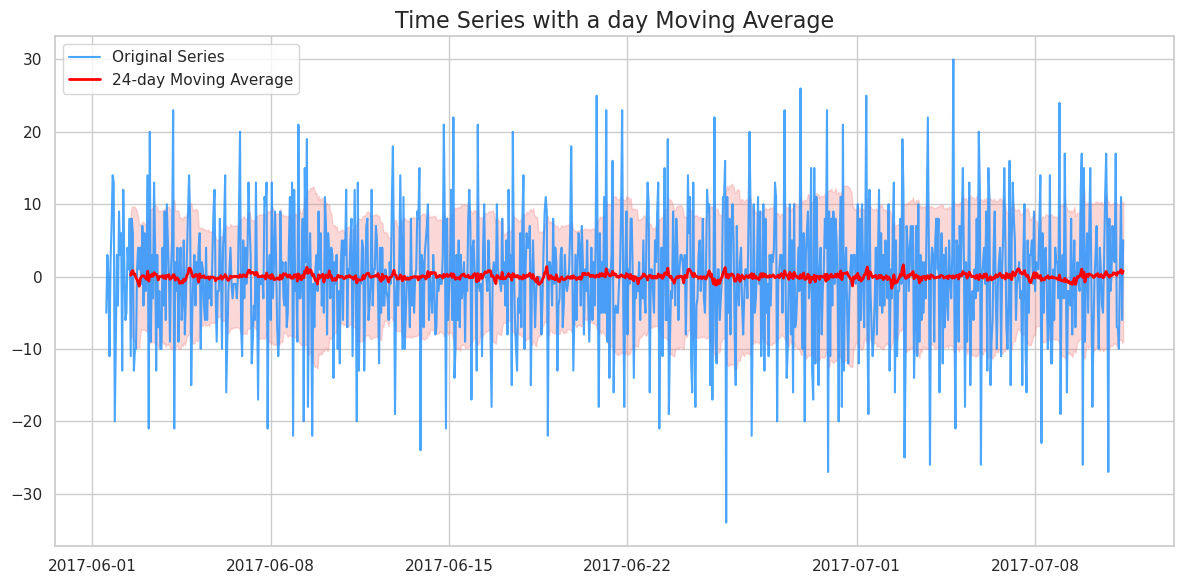

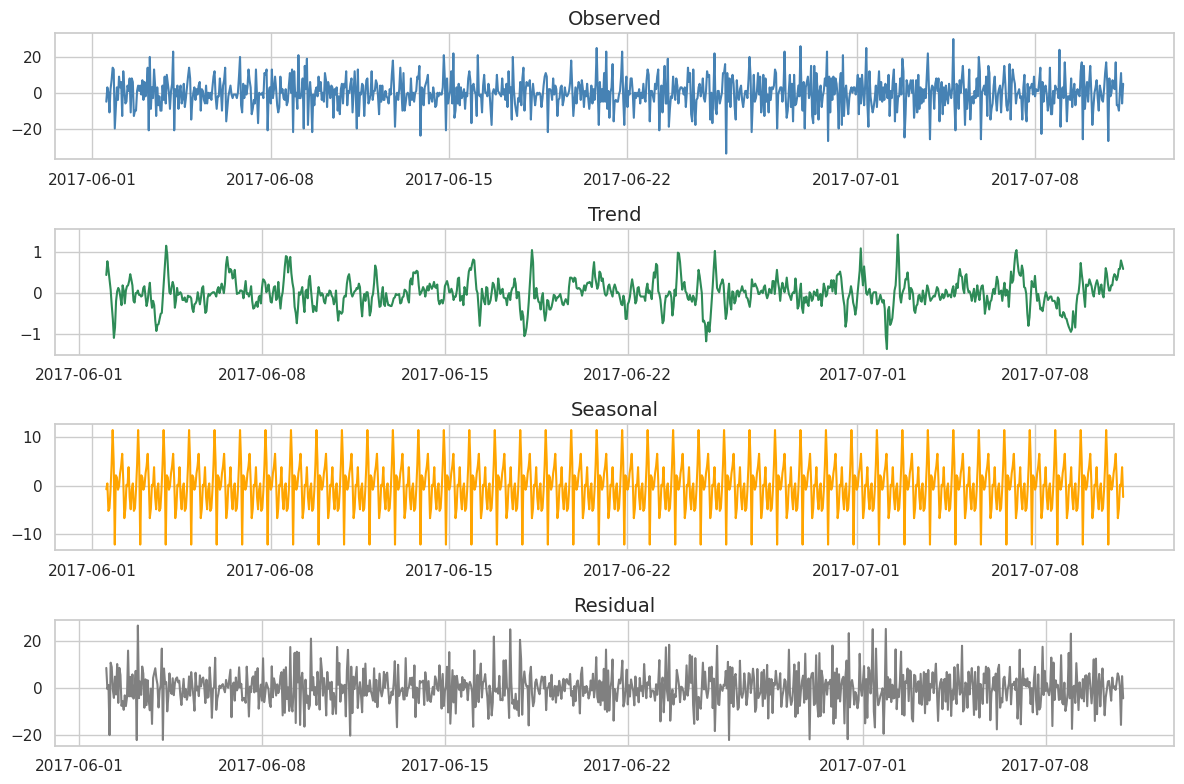

Descriptive Statistics:
count    959.000000
mean       0.017727
std        8.859887
min      -34.000000
25%       -5.000000
50%        0.000000
75%        5.000000
max       30.000000
Name: H404, dtype: float64

Shapiro-Wilk Test p-value: 1.423741764483566e-06
Interpretation: p < 0.05 suggests the data is not normally distributed

Augmented Dickey-Fuller Test for Stationarity:
ADF Statistic: -18.73191306456837
p-value: 2.030671611577601e-30
Interpretation:
p < 0.05: Reject null hypothesis (Series is stationary)
p >= 0.05: Fail to reject null hypothesis (Series might be non-stationary)


In [13]:
univariate_data_analysis(ts.diff().dropna())

We can see that after the **differentiation**, de data is almost normal, and at least for sarimax modeling, it looks good, so we'll **experiment** with different types of differentiation with the models.

# Then We Split the Data and Model  

The `time_series_forecasting` function applies a **Min-Max scaling transformation** to help the model converge faster. It then:  

1. **Creates daily sequences**  
2. **Reshapes the data** for each specific architecture  
3. **Trains 12 different architectures** (3 per model) with **early stopping** for 200 epochs  
4. **Selects the best model** based on the lowest **MAE**  
5. **Plots its predictions** and comparisons with the test data  

This ensures we find the most effective model for the given time series data.  


Train: 623, Validation: 143, Test: 145


/home/pepechuy/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-03 22:16:44.713335: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/pepechuy/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/pepechuy/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_s

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
MLP Model 1 MAE: 5.7862767188017035
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MLP Model 2 MAE: 5.7162015832140884
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x74ca8eccfa60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MLP Model 3 MAE: 5.654867527144384
4/4 ━━━━━━━━━━━━━━━

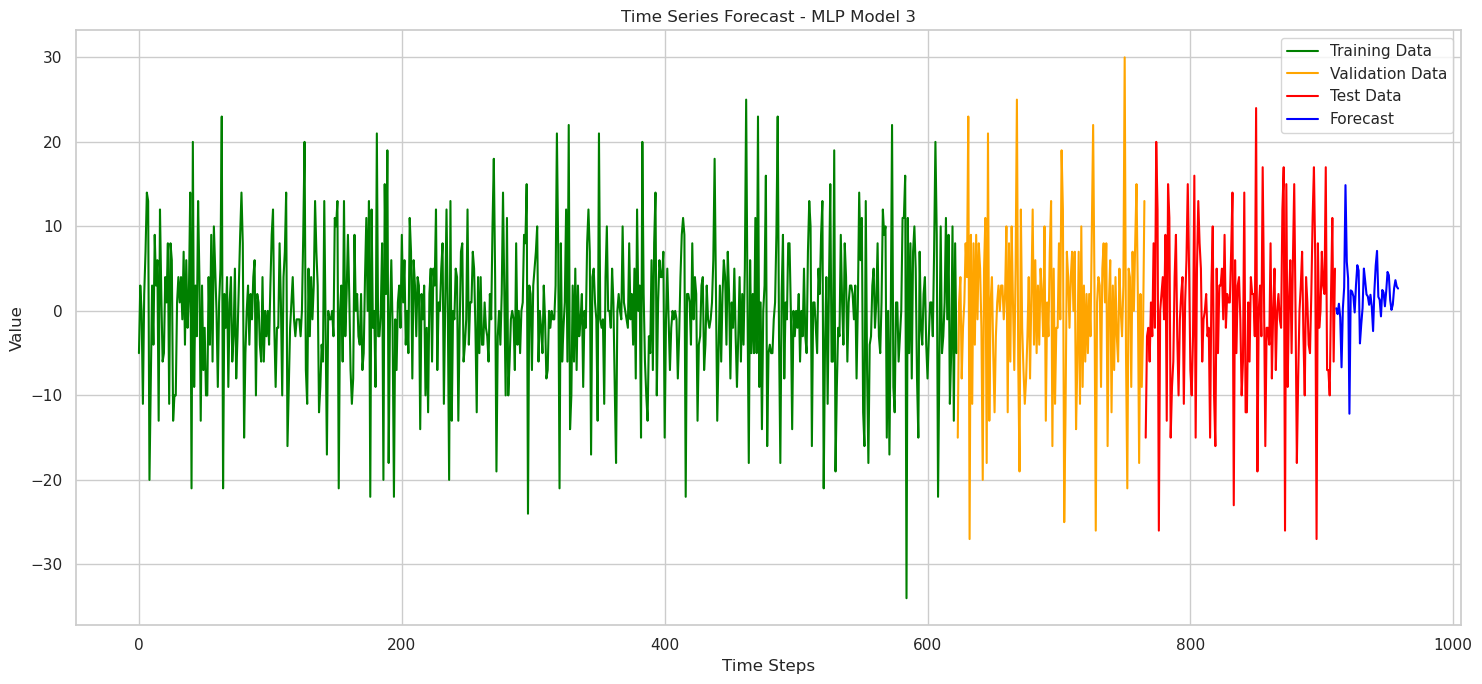

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


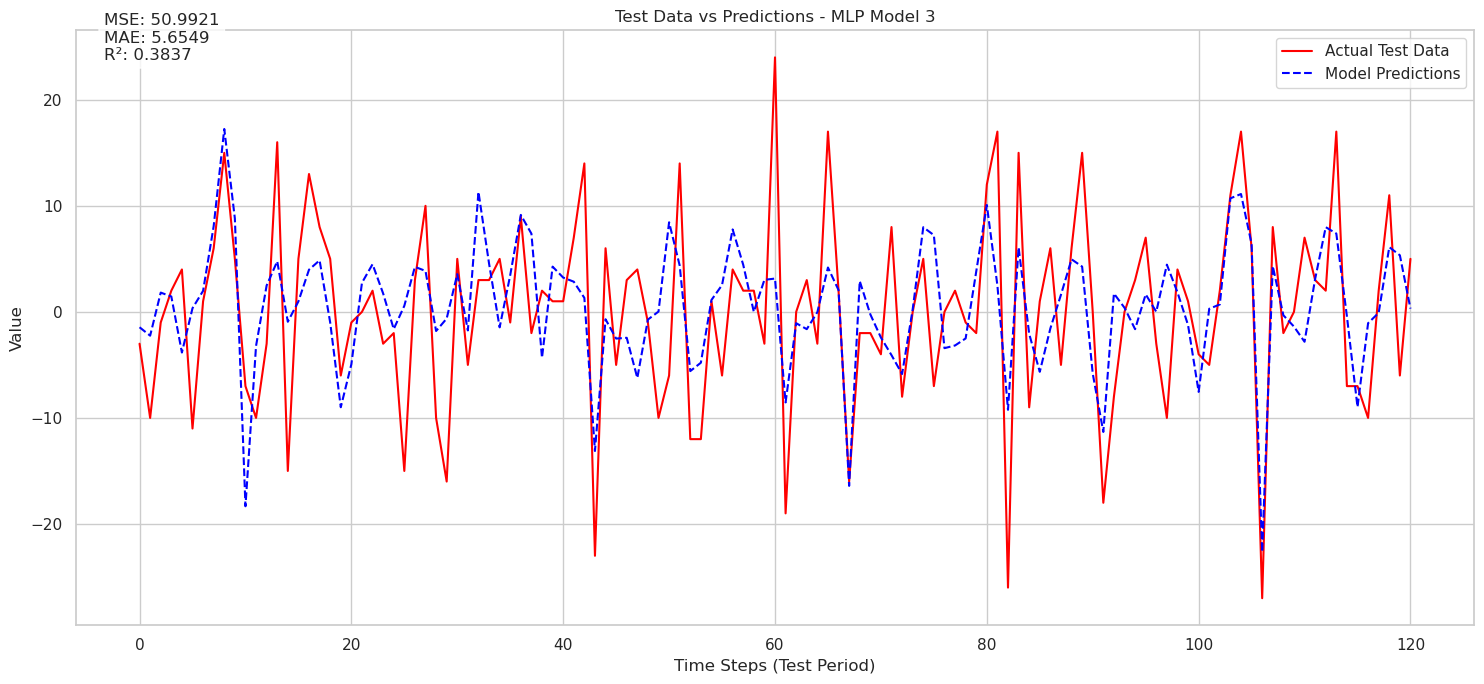


Model Performance Comparison:
      Model Type  Mean Absolute Error
     MLP Model 3             5.654868
     CNN Model 1             5.661280
     MLP Model 2             5.716202
    LSTM Model 3             5.784736
     MLP Model 1             5.786277
CNN-LSTM Model 3             5.823604
CNN-LSTM Model 1             5.882099
    LSTM Model 1             5.931128
    LSTM Model 2             5.998845
     CNN Model 3             6.427719
     CNN Model 2             6.507568
CNN-LSTM Model 2             7.098802


In [8]:
train_data, val_data, test_data = split_data(ts.diff().dropna())
best_model = time_series_forecasting(train_data, val_data, test_data)

Train: 607, Validation: 140, Test: 141


/home/pepechuy/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/pepechuy/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/pepechuy/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MLP Model 1 MAE: 6.72366912675719
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MLP Model 2 MAE: 7.367310229529682
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MLP Model 3 MAE: 6.630793996855744
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
CNN Model 1 MAE: 6.701416432093351
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
CNN Model 2 MAE: 8.807022420769064
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
CNN Model 3 MAE: 9.154560479852888
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
LSTM Model 1 MAE: 7.352535218000412
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
LSTM Model 2 MAE: 7.1846274173157845
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
LSTM Model 3 MAE: 7.165099249691026
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
CNN-LSTM Model 1 MAE: 7.0712676888857136
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
CNN-LSTM Model 2 MAE: 8.93237250763127
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
CNN-LSTM Model 3 MAE: 6.754494137488878

Best Model: MLP Model 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━

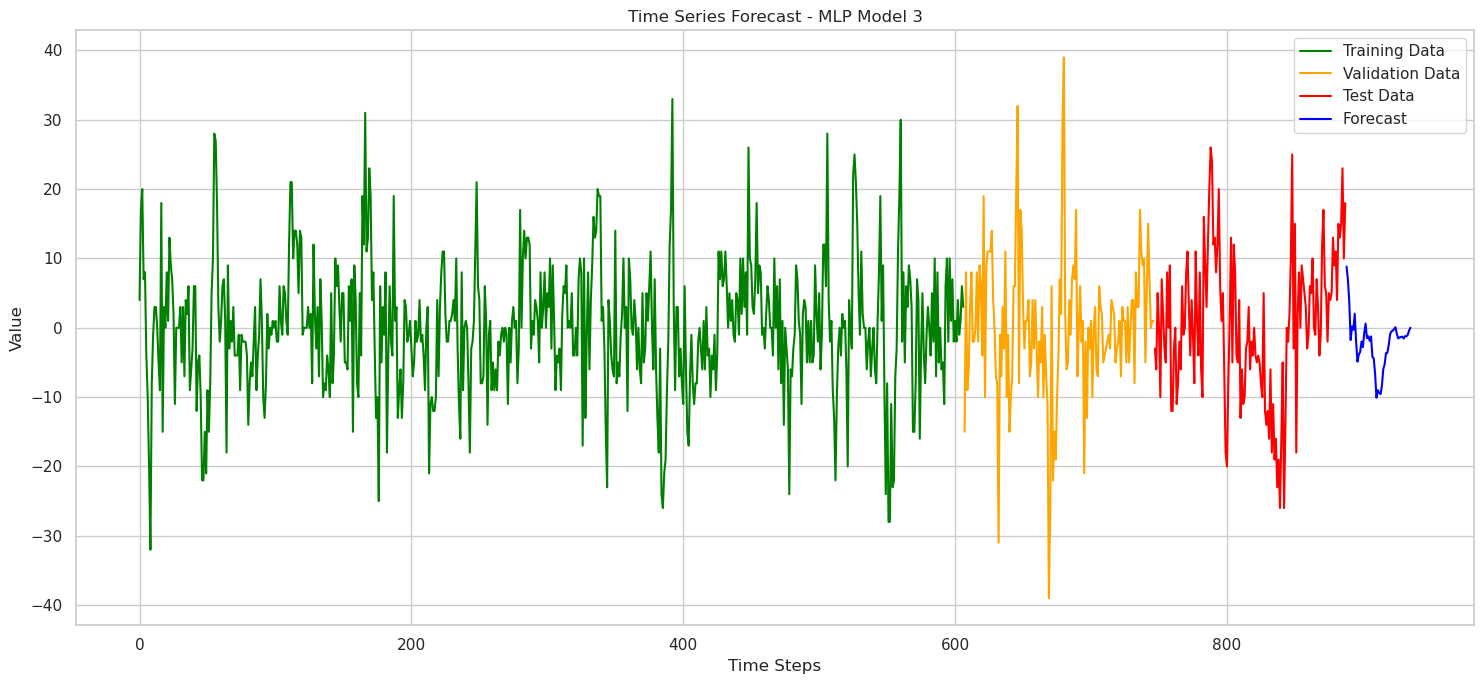

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


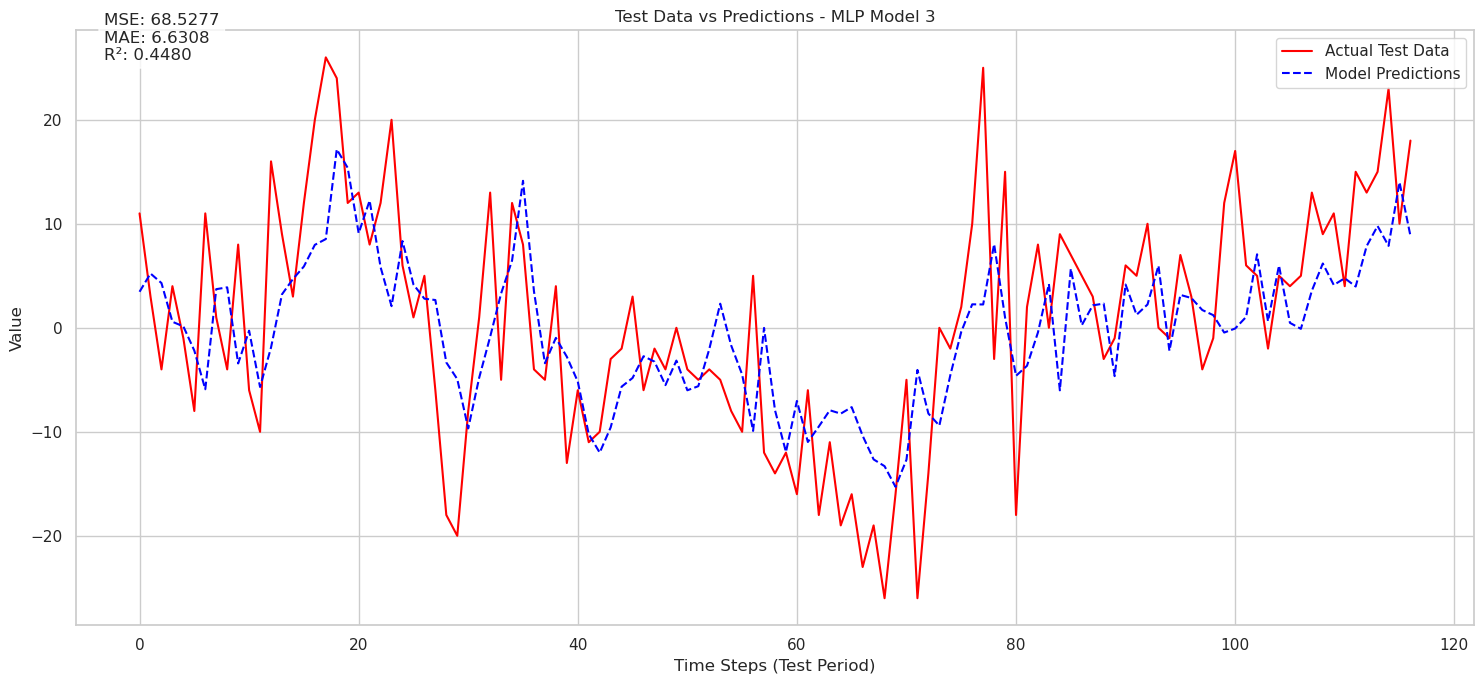


Model Performance Comparison:
      Model Type  Mean Absolute Error
     MLP Model 3             6.630794
     CNN Model 1             6.701416
     MLP Model 1             6.723669
CNN-LSTM Model 3             6.754494
CNN-LSTM Model 1             7.071268
    LSTM Model 3             7.165099
    LSTM Model 2             7.184627
    LSTM Model 1             7.352535
     MLP Model 2             7.367310
     CNN Model 2             8.807022
CNN-LSTM Model 2             8.932373
     CNN Model 3             9.154560


In [9]:
train_data, val_data, test_data = split_data(ts.diff(24).dropna())
best_model = time_series_forecasting(train_data, val_data, test_data)

Train: 606, Validation: 140, Test: 141


/home/pepechuy/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/pepechuy/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/pepechuy/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MLP Model 1 MAE: 6.713634262737046
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
MLP Model 2 MAE: 6.806079277625451
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MLP Model 3 MAE: 6.777761671278212
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
CNN Model 1 MAE: 6.795207960992797
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
CNN Model 2 MAE: 7.882661786853758
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
CNN Model 3 MAE: 7.252414246909638
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
LSTM Model 1 MAE: 6.529460042969793
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
LSTM Model 2 MAE: 6.6744681301279964
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
LSTM Model 3 MAE: 6.750089172624115
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
CNN-LSTM Model 1 MAE: 6.5088491847372465
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
CNN-LSTM Model 2 MAE: 7.242391406980335
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
CNN-LSTM Model 3 MAE: 6.820558466463008

Best Model: CNN-LSTM Model 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/ste

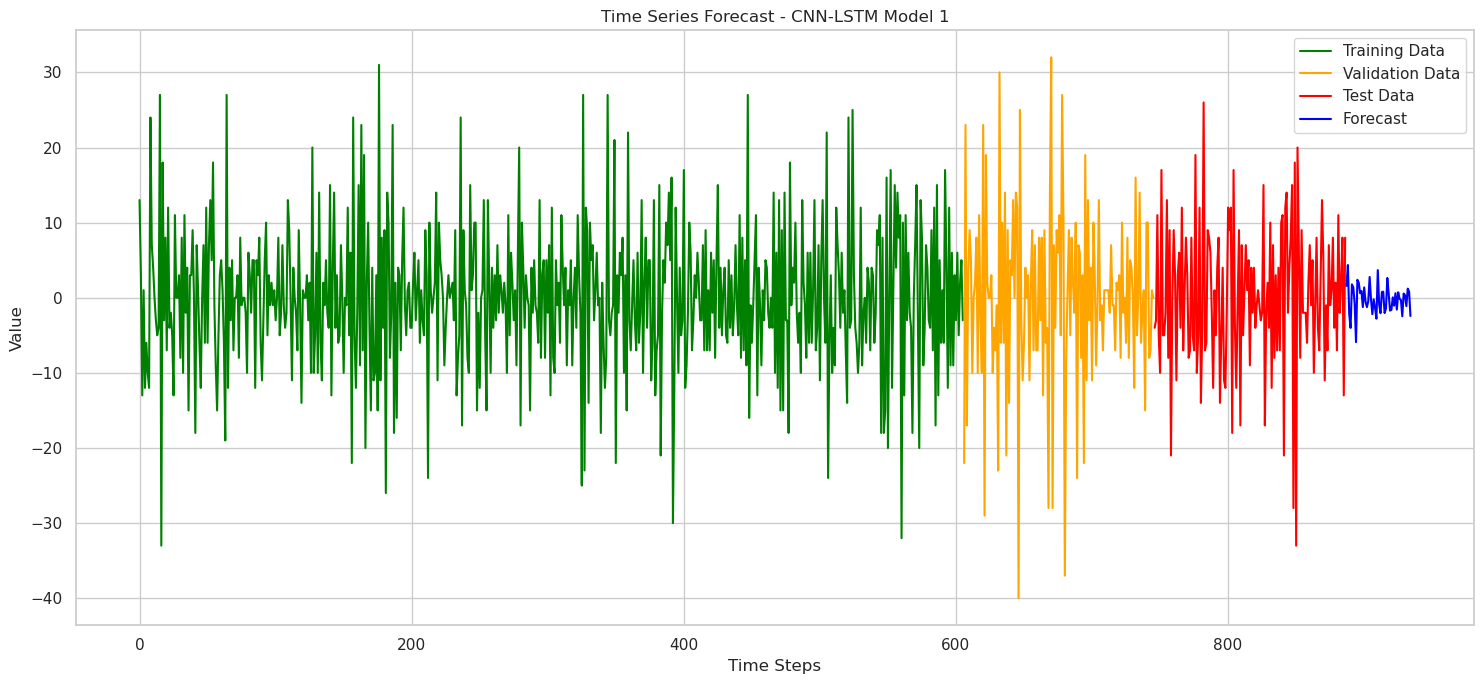

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


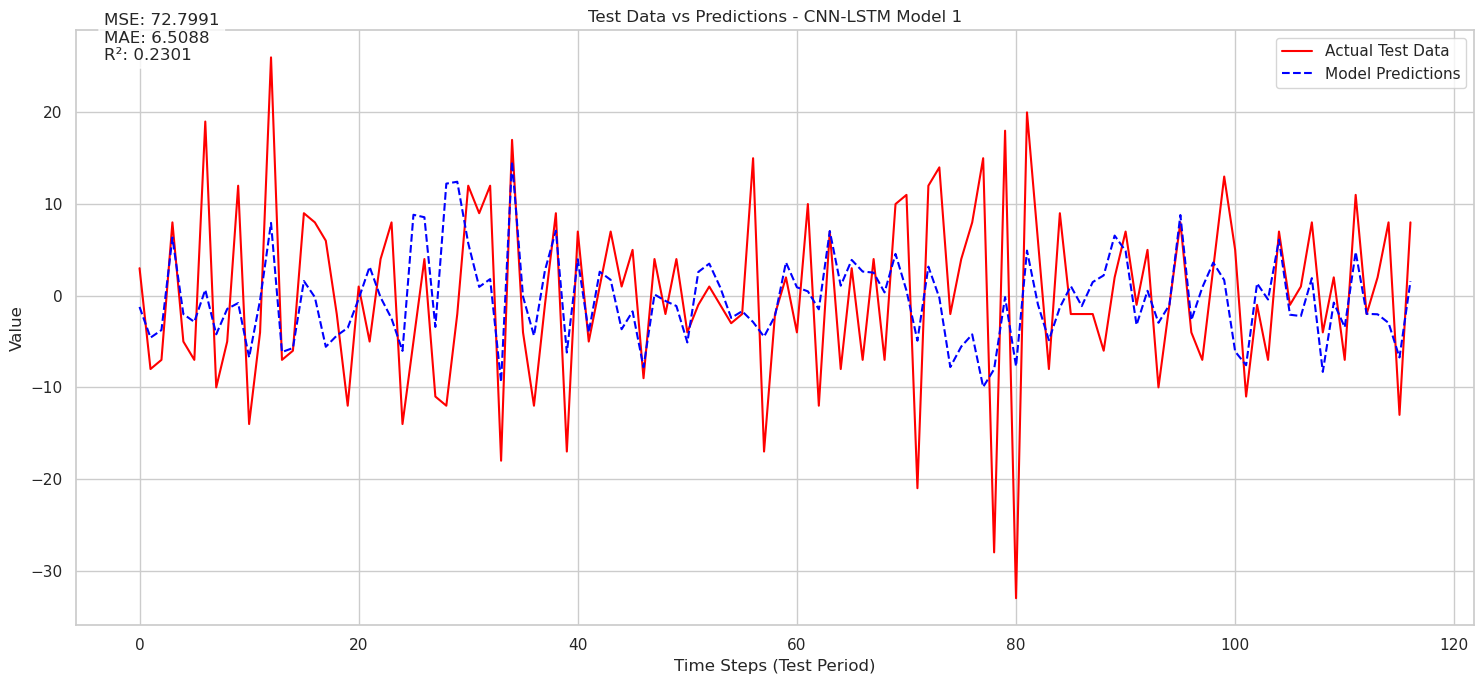


Model Performance Comparison:
      Model Type  Mean Absolute Error
CNN-LSTM Model 1             6.508849
    LSTM Model 1             6.529460
    LSTM Model 2             6.674468
     MLP Model 1             6.713634
    LSTM Model 3             6.750089
     MLP Model 3             6.777762
     CNN Model 1             6.795208
     MLP Model 2             6.806079
CNN-LSTM Model 3             6.820558
CNN-LSTM Model 2             7.242391
     CNN Model 3             7.252414
     CNN Model 2             7.882662


In [10]:
train_data, val_data, test_data = split_data(ts.diff(24).diff().dropna())
best_model = time_series_forecasting(train_data, val_data, test_data)

Train: 624, Validation: 144, Test: 144


/home/pepechuy/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/pepechuy/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/pepechuy/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
MLP Model 1 MAE: 5.541786559422812
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
MLP Model 2 MAE: 5.727712798118591
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
MLP Model 3 MAE: 5.757807381947836
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
CNN Model 1 MAE: 5.610135300954183
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
CNN Model 2 MAE: 6.044717137018839
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
CNN Model 3 MAE: 8.688598076502482
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
LSTM Model 1 MAE: 6.500015592575073
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
LSTM Model 2 MAE: 6.327711772918701
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
LSTM Model 3 MAE: 5.819276523590088
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
CNN-LSTM Model 1 MAE: 6.199421048164368
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
CNN-LSTM Model 2 MAE: 7.10911336739858
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
CNN-LSTM Model 3 MAE: 6.144882734616598

Best Model: MLP Model 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━

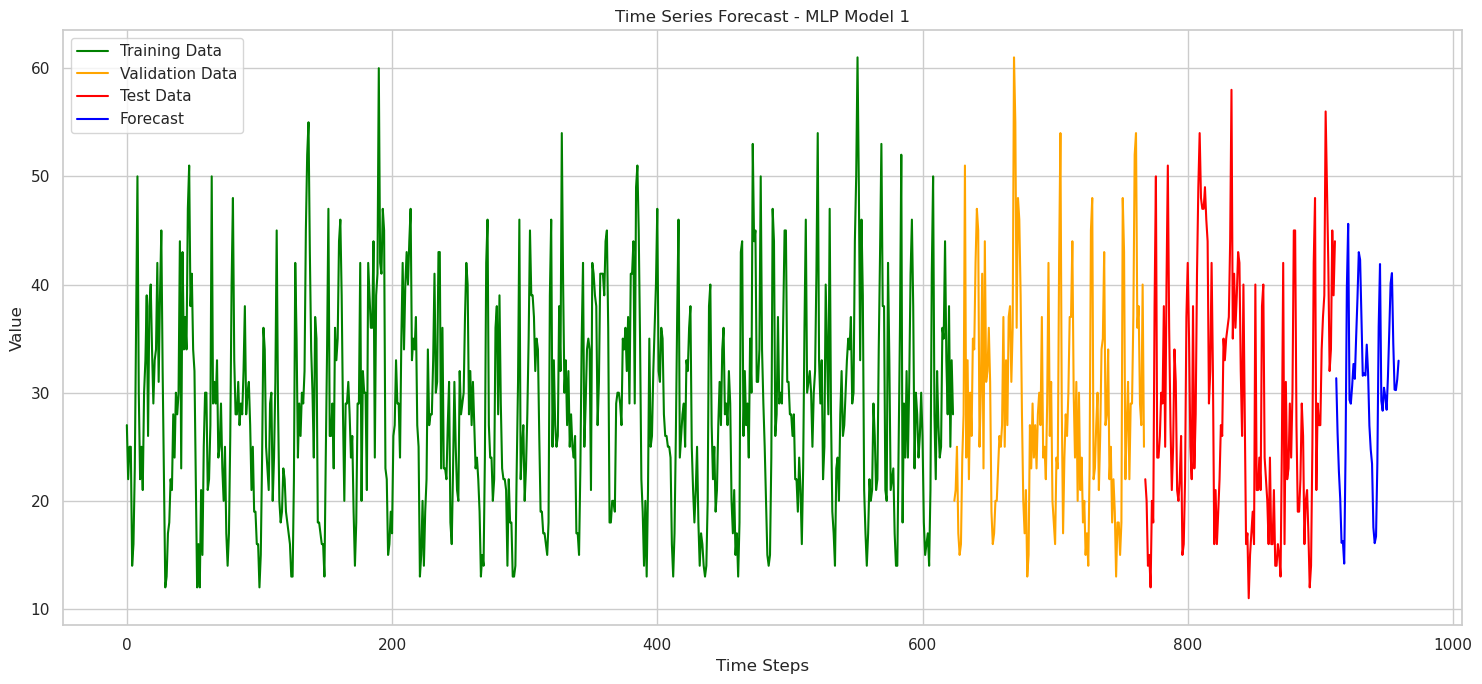

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


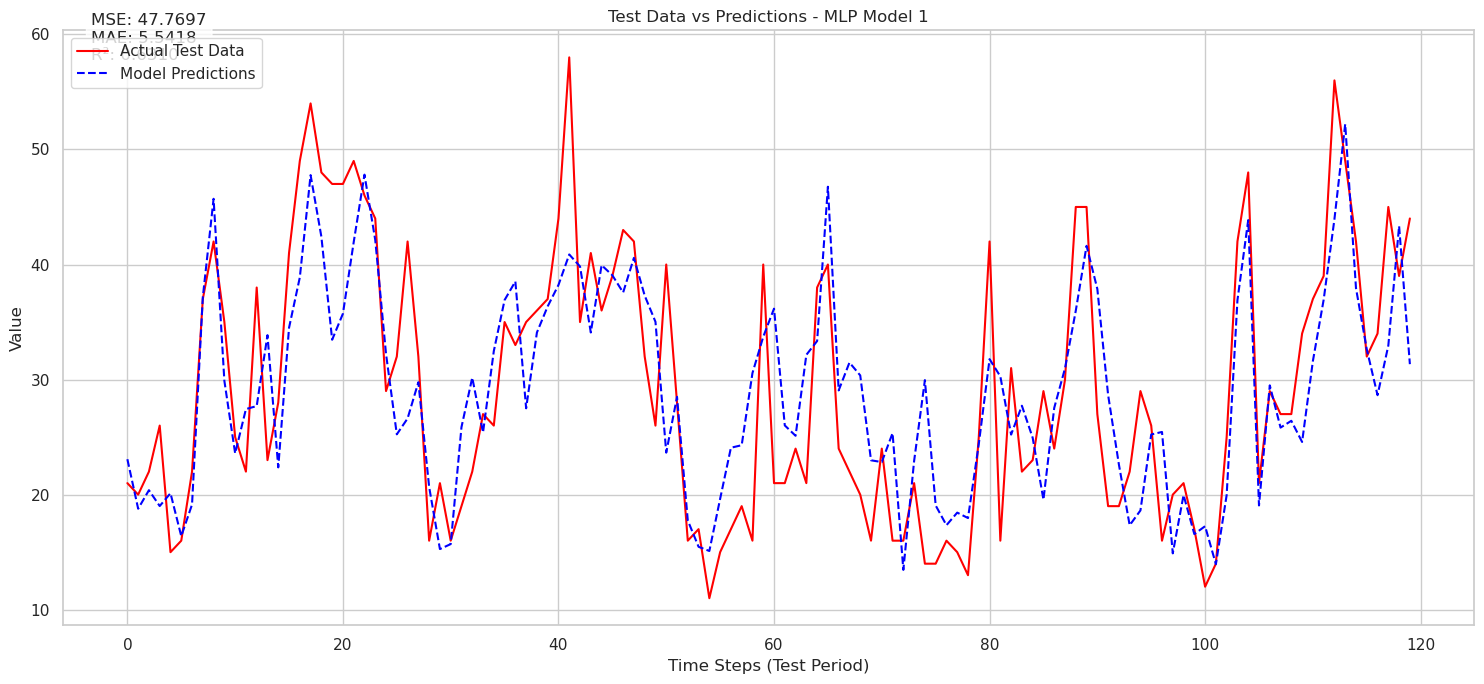


Model Performance Comparison:
      Model Type  Mean Absolute Error
     MLP Model 1             5.541787
     CNN Model 1             5.610135
     MLP Model 2             5.727713
     MLP Model 3             5.757807
    LSTM Model 3             5.819277
     CNN Model 2             6.044717
CNN-LSTM Model 3             6.144883
CNN-LSTM Model 1             6.199421
    LSTM Model 2             6.327712
    LSTM Model 1             6.500016
CNN-LSTM Model 2             7.109113
     CNN Model 3             8.688598


In [11]:
train_data, val_data, test_data = split_data(ts)
best_model = time_series_forecasting(train_data, val_data, test_data)

### Conclusion
After all the experiments, we can conclude that the best model works with the **original (non-differentiated) data**.  
- The **first simple differentiation** did not improve performance significantly.  
- The **24-step differentiation**, as well as the **24-step + single differentiation**, resulted in slightly higher errors.  
Therefore, we will proceed using the **normal data** for modeling.

- And also we wont have to worry about the data scaling

In [6]:
best_model['best_model'].summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,997 (582.02 KB)

 Trainable params: 49,665 (194.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,332 (388.02 KB)

# Optuna

After that, we select the model that gave the best results and optimize it with **Optuna** for:  
- **Learning rate**  
- **Activation functions**  
- **Number of layers**  
- **Number of units per layer**  
- **Optimizer**  

The function is designed to **adapt** and tune the best model architecture **regardless of its type**, as different models can perform better depending on the series. Our goal is to achieve the **optimal performance** possible.  

The experiment runs for **200 trials**, then the results are **de-scaled** and plotted against the **test set**, allowing us to compare with the previous model.  


[I 2025-04-03 01:25:44,623] A new study created in memory with name: no-name-3f2f44f1-9bc1-4b01-b146-b87f67e6de47
c:\Users\dosju\Downloads\Examen2NL\pipeline.py:690: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
C:\Users\dosju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-04-03 01:26:26,635] Trial 0 finished with value: 0.11200647056102753 and parameters: {'optimizer': 'rmsprop', 'learning

Best MLP Model Optimization Results:
  Number of trials: 200
  Best trial value (MAE): 0.09540198743343353
  Best hyperparameters:
    optimizer: rmsprop
    learning_rate: 0.0032123779744211976
    activation: relu
    n_layers: 4
    neurons_0: 190
    neurons_1: 78
    dropout_1: 0.17784155130898066
    neurons_2: 53
    dropout_2: 0.09180453107390942
    neurons_3: 47
    dropout_3: 0.08937649684129227
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━

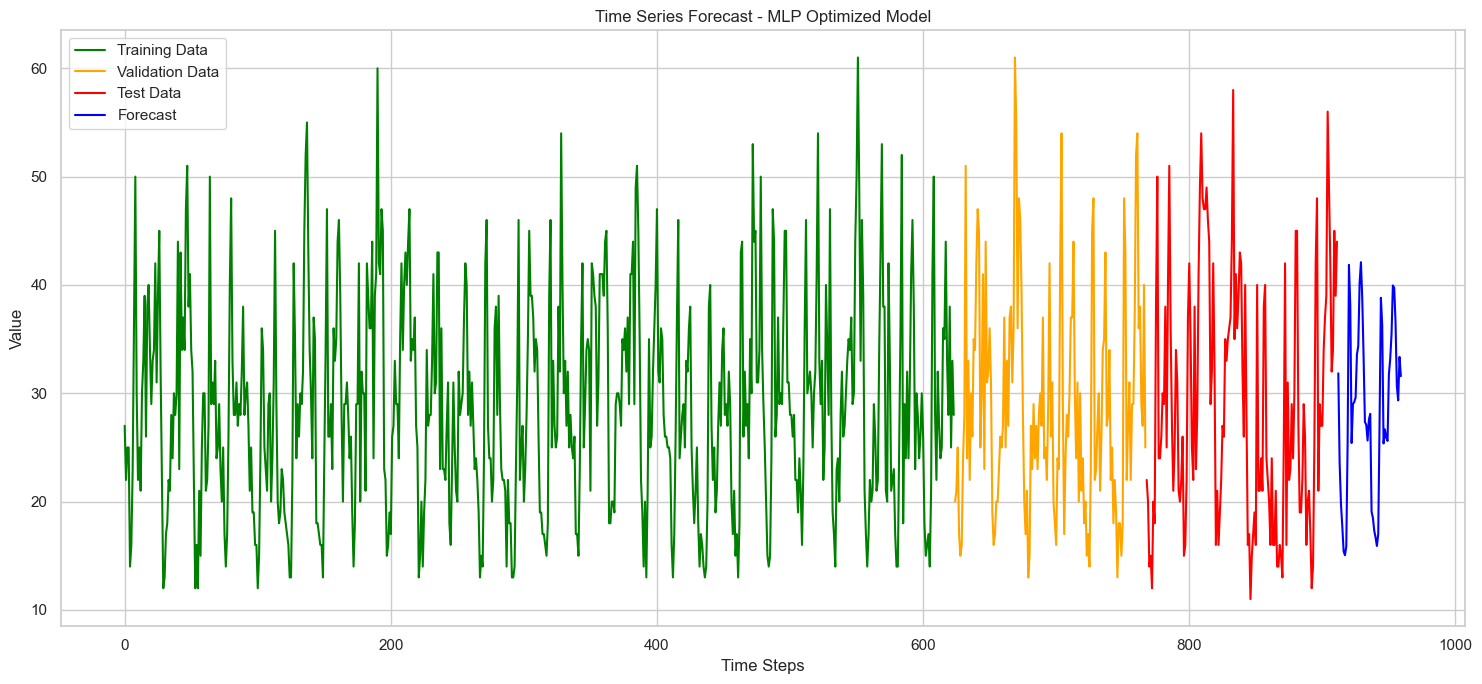


Test Data Prediction Analysis:


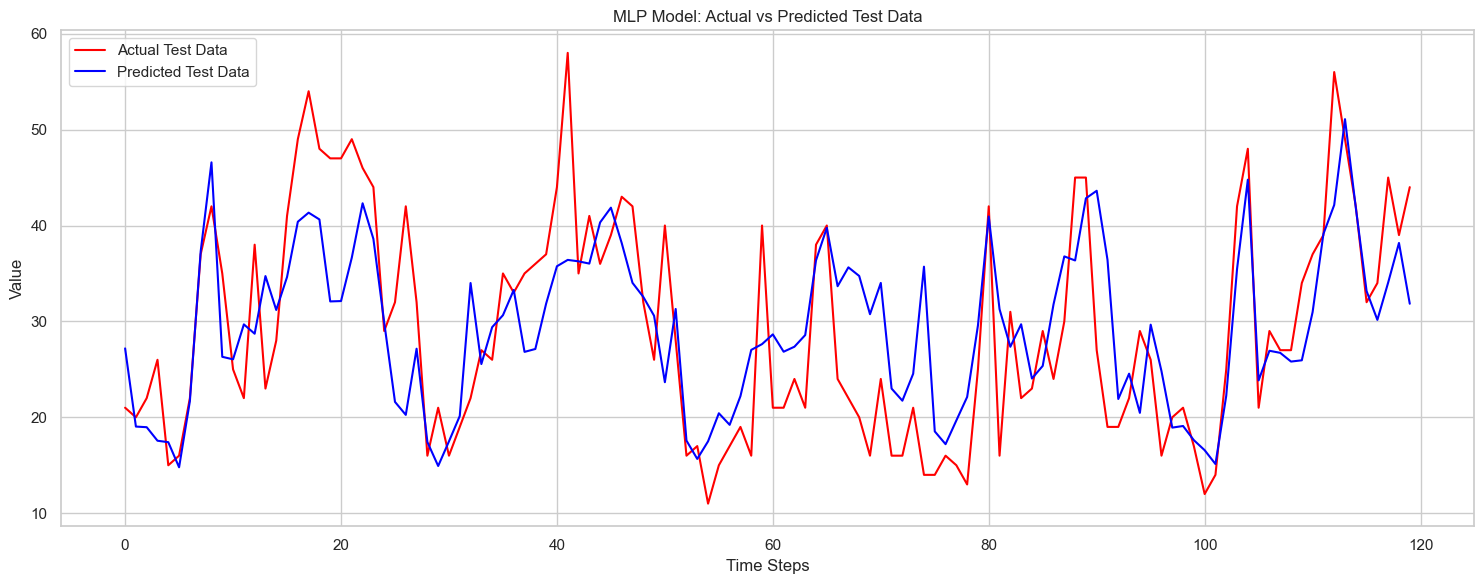


Model Performance Metrics:
Mean Absolute Error (MAE): 6.069634064038595
Mean Squared Error (MSE): 62.20094087733805


In [7]:
result = optimize_model(train_data, val_data, test_data, n_steps=24, model_type='mlp', n_trials=200)
best_model = result['best_model']
best_params = result['best_params']
scaler = result['scaler']

## Best MLP Model Optimization Results

### Summary
- **Number of trials:** 200  
- **Best trial value (MAE):** 0.09540198743343353  
- **Best hyperparameters:**  
  - **Optimizer:** rmsprop  
  - **Learning rate:** 0.0032123779744211976  
  - **Activation:** relu  
  - **Number of layers:** 4  
  - **Neurons per layer:**  
    - **Layer 0:** 190  
    - **Layer 1:** 78  
    - **Layer 2:** 53  
    - **Layer 3:** 47  
  - **Dropout:**  
    - **Layer 1:** 0.17784155130898066  
    - **Layer 2:** 0.09180453107390942  
    - **Layer 3:** 0.08937649684129227  



We achieved a **6.069 MAE**, on the test data which is a good model but didnt over perform the manually defined model that got a **5.541787 MAE**

However, the **Optuna-optimized model** in this case, again, proposed a more **complex model** than the original proposed.  

For the seccond time, our vanilla model was the best. 